# Fractional Cover Collection 3 Validation

This notebook generates plots and statistics comparing Fractional Cover Collection 2 (FC2) and 3 (FC3). The plots are:

- a triangle plot for FC2 and 3 for each scene and all combined scenes
- a plot showing the spatial difference for each FC band between Collection 2 and 3 for each scene and the all-time median

The statistics are:

- The number of pixels along the triangle edges (scene and total) i.e. the number of saturated FC pixels
- The mean difference between FC2 and FC3 in FC-space (scene and total)
- The standard defviation of the difference between FC2 and FC3 in FC-space (scene and total)

Each of these plots and statistics will be calculated for each Landsat satellite separately.

## Getting started

Import some modules:

In [3]:
import datacube
from odc.ui import with_ui_cbk
import matplotlib.pyplot as plt
import matplotlib.cm
import numpy as np
import scipy.stats
import pandas as pd
import xarray as xr
from tqdm.auto import tqdm

import sys
sys.path.insert(1, '../../Scripts')
import dea_datahandling

Load the datacube:

In [4]:
dc = datacube.Datacube(app="FC3Validation")

### Analysis parameters

Location:

In [5]:
# Toowoomba
# latitudes = (-27.31, -27.41)
# longitudes = (151.01, 151.12)

# Menindee
longitudes = 142.138830, 142.502419
latitudes = -32.512952, -32.174746

Date range:

In [6]:
time = ('1988', '2019')

What kind of interpolation to use for plotting spatial FC:

In [7]:
interpolation = 'gaussian'

## Load data

### Load fractional cover

Build a query for each Landsat platform:

In [8]:
query = {i: {
    "resolution": (-30, 30),
    "group_by": "solar_day",
#     "region_code": "090079",
    'platform': f'landsat-{i}',
    "lat": latitudes,
    "lon": longitudes,
    "time": time,
} for i in [5, 7, 8]}

In [9]:
products = {5: 'ga_ls5t_ard_3', 7: 'ga_ls7e_ard_3', 8: 'ga_ls8c_ard_3'}

In [10]:
def get_crs(*args, **kwargs):
    """Wrapper for dea_datahandling.mostcommon_crs which catches exceptions and returns a default CRS."""
    try:
        return dea_datahandling.mostcommon_crs(*args, **kwargs)
    except IndexError:
        return 'EPSG:3577'

In [11]:
output_crs = {i: get_crs(dc, p, query[i]) for i, p in products.items()}
for i in products:
    query[i]['output_crs'] = output_crs[i]

Load FC3:

In [12]:
ds_fc3 = {i: dc.load(
    product="ga_ls_fc_3",
    **query[i],
    resampling="bilinear",
    progress_cbk=with_ui_cbk(),
    dask_chunks={},
) for i in products}

And load FC2:

In [13]:
ds_fc2 = {i: dc.load(
    product=f"ls{i}_fc_albers",
    **{k: v for k, v in query[i].items() if k not in {'lon', 'lat', 'platform', 
                                                      'region_code', 'output_crs', 'resolution'}},
    like=ds_fc3[i],
    resampling="bilinear",
    dask_chunks={},
) for i in products}

Load C3 ARD:

In [14]:
ds_ard3 = {i: dc.load(
    product=products[i],
    **{k: v for k, v in query[i].items() if k not in {'lon', 'lat', 'platform', 
                                                      'region_code', 'output_crs', 'resolution'}},
    like=ds_fc3[i],
    resampling="bilinear",
    dask_chunks={},
) for i in products}

Determine which have data:

In [15]:
has_data = {i: len(ds_fc3[i]) > 0 for i in products}

### Load a WOfS mask

Load WOfS from Collection 3 to mask both datasets. This keeps the mask the same so they can be compared.

In [16]:
wofs = {i: dc.load(
    product=f"ga_ls_wo_3",
    **{k: v for k, v in query[i].items() if k not in {'lon', 'lat', 'platform', 
                                                      'region_code', 'output_crs', 'resolution'}},
    like=ds_fc3[i],
    resampling="nearest",
    progress_cbk=with_ui_cbk(),
    dask_chunks={},
) if has_data[i] else ds_fc3[i] for i in products}

In [17]:
wofs_mask = {i: wofs[i] == 0 for i in products}  # Dry and clear only

### Align time for Collection 2 and Collection 3

In [18]:
# Remove milliseconds to make data comparable
for i in products:
    if not has_data[i]:
        continue
    ds_fc2[i]["time"] = ds_fc2[i].indexes["time"].normalize()
    ds_fc3[i]["time"] = ds_fc3[i].indexes["time"].normalize()
    wofs_mask[i]["time"] = wofs_mask[i].indexes["time"].normalize()
    ds_ard3[i]["time"] = ds_ard3[i].indexes["time"].normalize()

    ds_fc3[i] = ds_fc3[i].sel(time=~ds_fc3[i].indexes['time'].duplicated(keep='first'))
    ds_fc2[i] = ds_fc2[i].sel(time=~ds_fc2[i].indexes['time'].duplicated(keep='first'))
    ds_ard3[i] = ds_ard3[i].sel(time=~ds_ard3[i].indexes['time'].duplicated(keep='first'))
    wofs_mask[i] = wofs_mask[i].sel(time=~wofs_mask[i].indexes['time'].duplicated(keep='first'))

In [19]:
# df = df.loc[~df.index.duplicated(keep='first')]
# Remove duplicate time steps

In [20]:
# Match timesteps
for i in products:
    if not has_data[i]:
        continue
    ds_compare = sorted(set(ds_fc3[i].time[ds_fc3[i]["time"].isin(ds_fc2[i]["time"].values) & ds_fc3[i]["time"].isin(ds_ard3[i]["time"].values)].values))
    ds_fc3_sel = ds_fc3[i].sel(time=ds_compare)
    ds_fc2_sel = ds_fc2[i].sel(time=ds_compare)
    ds_ard3_sel = ds_ard3[i].sel(time=ds_compare)
#         ds_fc2_sel = ds_fc2[i].where(ds_fc2[i].time == ds_fc3[i].time)
    ds_fc3[i] = ds_fc3_sel
    ds_fc2[i] = ds_fc2_sel
    ds_ard3[i] = ds_ard3_sel

### Rename Collection 2 variables to match Collection 3

In [21]:
for i in products:
    if not has_data[i]:
        continue
    ds_fc2[i] = ds_fc2[i].rename_vars({"BS": "bs", "PV": "pv", "NPV": "npv", "UE": "ue"})

### Replace the nodata with NaNs

Each product has a different nodata value:

In [22]:
for i in products:
    if not has_data[i]:
        continue
    print(
        ds_fc2[i].bs.nodata,
        ds_fc3[i].bs.nodata,
        ds_ard3[i].nbart_red.nodata,
        ds_ard3[i].oa_fmask.nodata,
    )

-1 255 -999 0
-1 255 -999 0
-1 255 -999 0


So mask each of them:

In [23]:
for i in products:
    if not has_data[i]:
        continue
    ds_fc2[i] = ds_fc2[i].where(ds_fc2[i] != -1)
    ds_fc3[i] = ds_fc3[i].where(ds_fc3[i] != 255)
    ds_ard3[i] = ds_ard3[i].where(ds_ard3[i] != -999)

Then mask by WOfS:

In [24]:
for i in products:
    if not has_data[i]:
        continue
    ds_fc2[i] = ds_fc2[i].where(wofs_mask[i].water)
    ds_fc3[i] = ds_fc3[i].where(wofs_mask[i].water)
    ds_ard3[i] = ds_ard3[i].where(wofs_mask[i].water)

## Comparison of spatial medians

We'll take the median of each stack of FC and compare them.

In [24]:
for i in tqdm(products):
    ds_fc2[i].load()
    ds_fc3[i].load()

In [28]:
median_fc2 = {i: ds_fc2[i].median(dim='time') if has_data[i] else ds_fc2[i] for i in products}
median_fc3 = {i: ds_fc3[i].median(dim='time') if has_data[i] else ds_fc3[i] for i in products}

/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1116: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/env/l

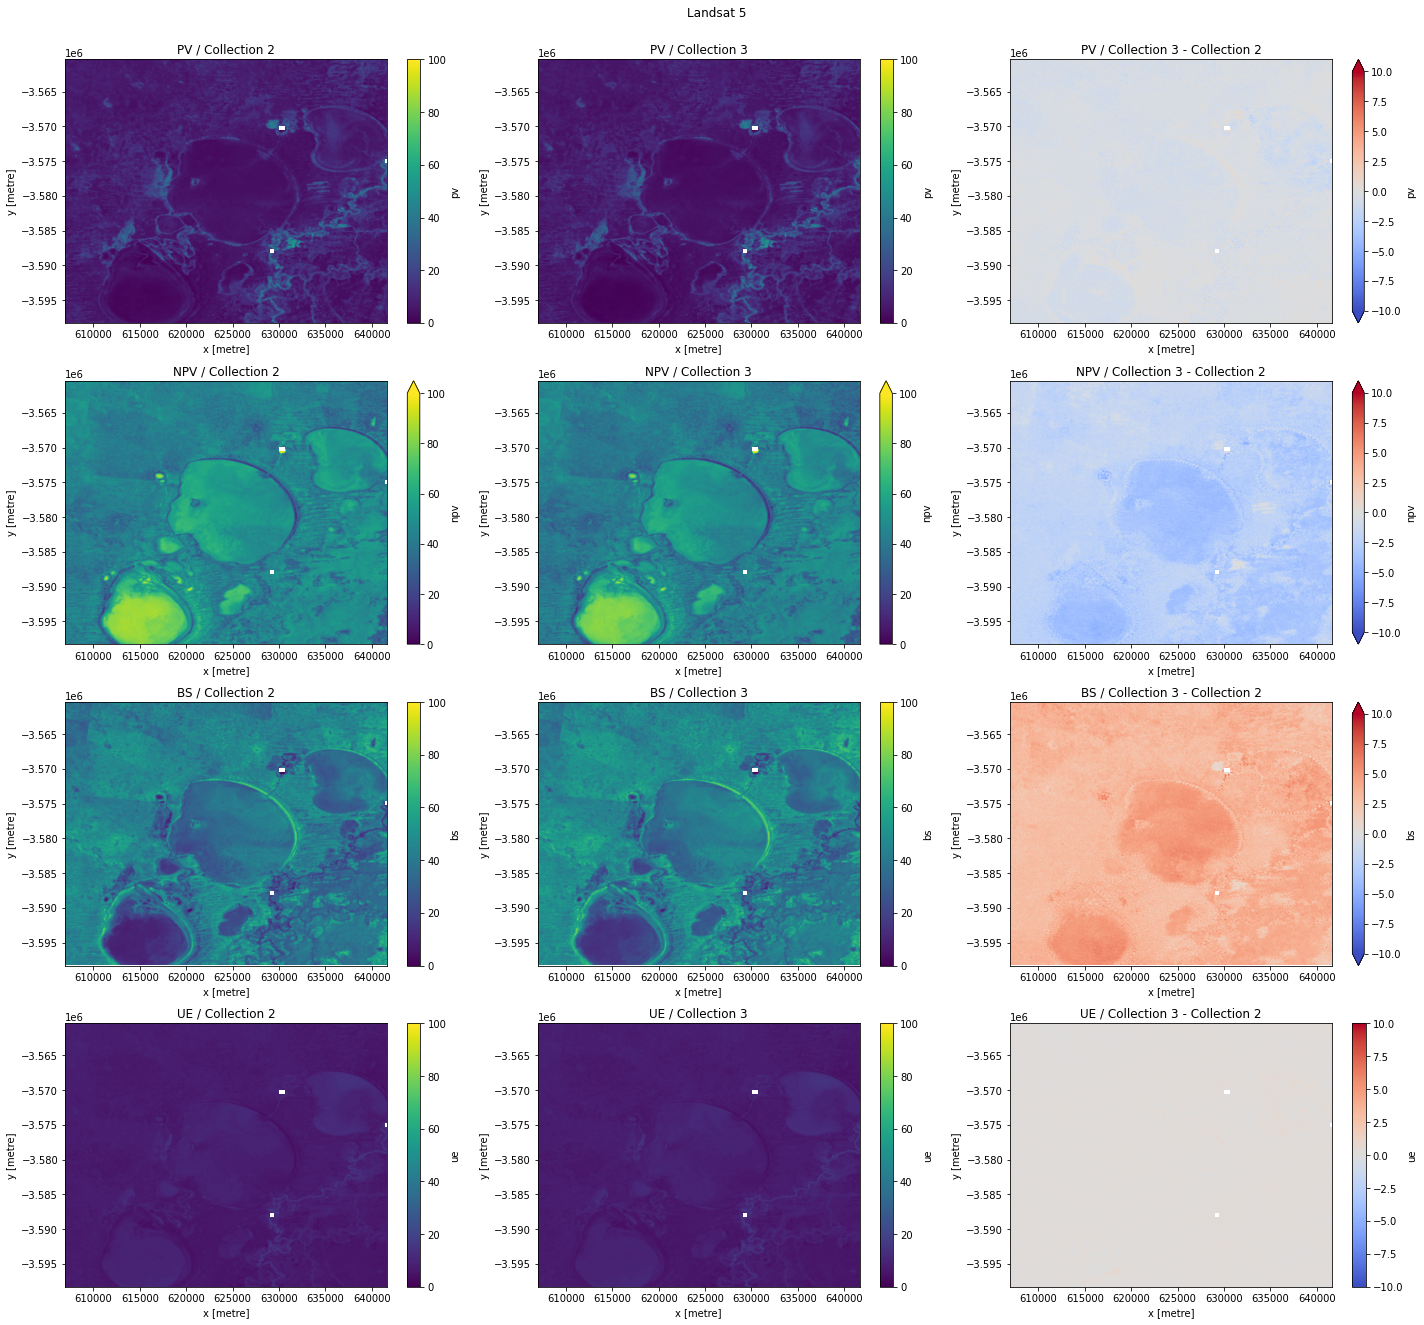

In [ ]:
for i in tqdm(products, position=0):
    if not has_data[i]:
        continue
    fig, axs = plt.subplots(4, 3, figsize=(20, 18))
    fig.suptitle(f'Landsat {i}', y=1.02)
    # Plot the FC2 and FC3 medians:
    for j, band in enumerate(tqdm(['pv', 'npv', 'bs', 'ue'], position=1, leave=False)):
        # FC2
        median_fc2[i][band].plot.imshow(ax=axs[j, 0], interpolation=interpolation, vmin=0, vmax=100)
        # FC3
        median_fc3[i][band].plot.imshow(ax=axs[j, 1], interpolation=interpolation, vmin=0, vmax=100)
        # Difference
        (median_fc3[i][band] - median_fc2[i][band]).plot.imshow(ax=axs[j, 2], interpolation=interpolation, vmin=-10, vmax=10, cmap='coolwarm')
        
        axs[j, 0].set_title(f'{band.upper()} / Collection 2')
        axs[j, 1].set_title(f'{band.upper()} / Collection 3')
        axs[j, 2].set_title(f'{band.upper()} / Collection 3 - Collection 2')
    plt.tight_layout()
    plt.show()

## All-time linear comparison plot

Another way we can compare FC between collections is to see how each band compares on a pixel-by-pixel basis. Let's plot them against each other. If the collections are identical, this should be a thin straight line; if they're identical up to noise, this should be a wide straight line.

There's a lot of points, so it's quite hard to visualise. We'll look at the first and ninety-ninth percentiles as well as the medians.

/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in greater_equal
/env/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


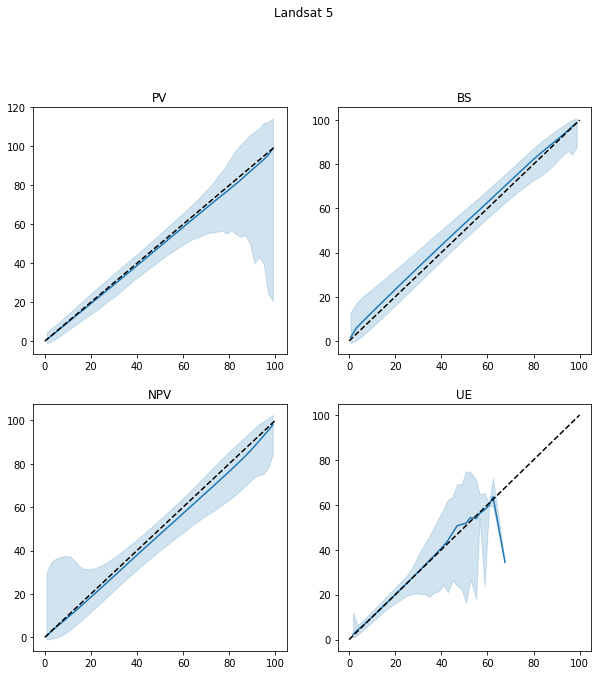

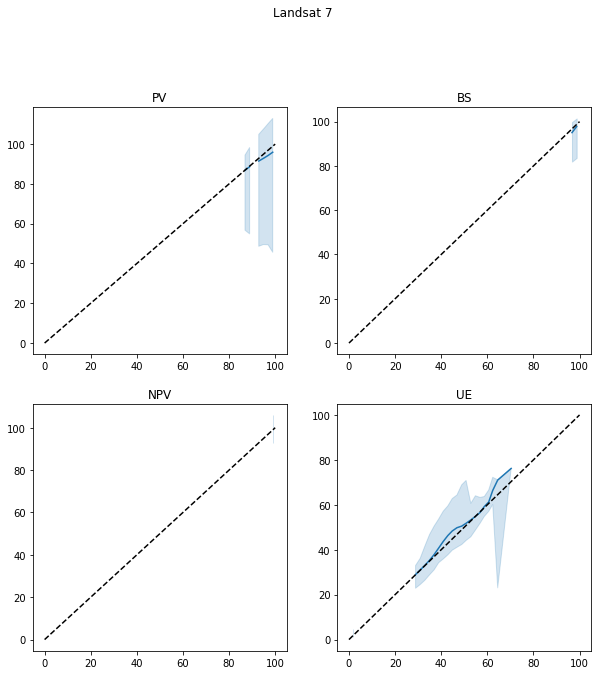

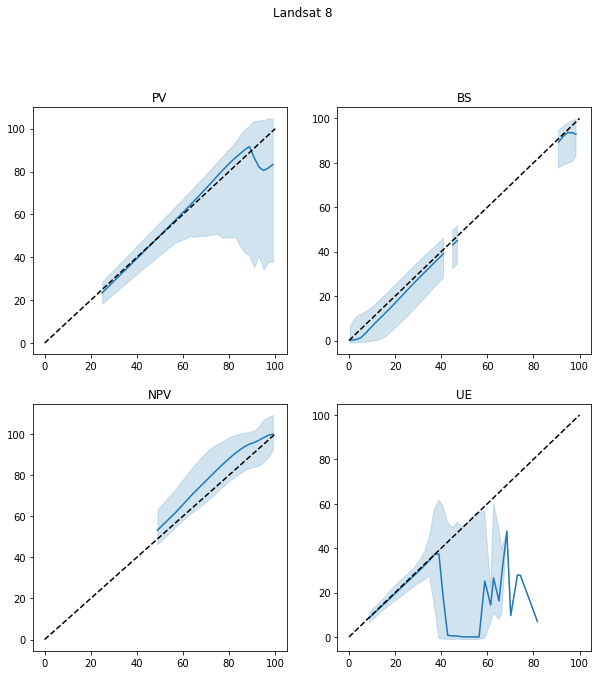

In [27]:
for i in tqdm(products, position=0):
    if not has_data[i]:
        continue
    
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs = [ax for axs_ in axs for ax in axs_]
    fig.suptitle(f'Landsat {i}', y=1.02)
    for j, band in enumerate(tqdm(["pv", "bs", "npv", "ue"], position=1, leave=False)):
        fc2 = ds_fc2[i][band].values.ravel()
        fc3 = ds_fc3[i][band].values.ravel()

        # add some noise to help visualise, because FC rounds to integers
        fc2 = fc2 + np.random.normal(0, 0.5, size=fc2.shape)
        fc3 = fc3 + np.random.normal(0, 0.5, size=fc3.shape)
        
        step = 2
        xs = []
        ys_99 = []
        ys_90 = []
        ys_50 = []
        ys_10 = []
        ys_01 = []
        for x_min in np.arange(0, 100, step):
            in_x_range = (fc2 >= x_min) & (fc2 < x_min + step)
            matching_fc2 = fc2[in_x_range]
            matching_fc3 = fc3[in_x_range]
            if len(matching_fc3) == 0:
                continue
            xs.append(np.median(matching_fc2))
            ys_99.append(np.percentile(matching_fc3, 99))
            ys_90.append(np.percentile(matching_fc3, 90))
            ys_50.append(np.percentile(matching_fc3, 50))
            ys_10.append(np.percentile(matching_fc3, 10))
            ys_01.append(np.percentile(matching_fc3, 1))

        axs[j].plot(xs, ys_50, c='C0')
        axs[j].fill_between(xs, ys_01, ys_99, color='C0', alpha=0.2)
        axs[j].plot([0, 100], [0, 100], color="black", linestyle='--')
        axs[j].set_title(band.upper())
    plt.show()

We can also look at the properties of the linear regression:

In [28]:
for i in products:
    if not has_data[i]:
        continue
    
    for j, band in enumerate(["pv", "bs", "npv", "ue"]):
        fc2 = ds_fc2[i][band].values.ravel()
        fc3 = ds_fc3[i][band].values.ravel()
        yes_nan = np.isnan(fc2) | np.isnan(fc3)
        lr = scipy.stats.linregress(fc2[~yes_nan], fc3[~yes_nan])
        print(f'Landsat {i} / {band.upper():>3}: R^2 = {lr.rvalue ** 2:.02f}, 3σ = {3 * lr.stderr:.02e}, offset = {lr.slope:.02f}')

Landsat 5 /  PV: R^2 = 0.98, 3σ = 2.27e-05, offset = 0.97
Landsat 5 /  BS: R^2 = 0.97, 3σ = 2.68e-05, offset = 0.99
Landsat 5 / NPV: R^2 = 0.96, 3σ = 3.33e-05, offset = 0.96
Landsat 5 /  UE: R^2 = 0.96, 3σ = 3.16e-05, offset = 0.98
Landsat 7 /  PV: R^2 = 0.98, 3σ = 2.36e-05, offset = 1.01
Landsat 7 /  BS: R^2 = 0.97, 3σ = 2.71e-05, offset = 0.97
Landsat 7 / NPV: R^2 = 0.95, 3σ = 3.43e-05, offset = 0.97
Landsat 7 /  UE: R^2 = 0.97, 3σ = 2.79e-05, offset = 0.99
Landsat 8 /  PV: R^2 = 0.95, 3σ = 6.04e-05, offset = 0.99


KeyboardInterrupt: 

## Triangle plots

We'll plot the FC distribution for each scene for C2 and C3, and also for all-time. We'll colour each point by its Landsat false colour.

In [29]:
def triangle_fc(fc_dataset, c3_ard, ax, **kwargs):
    """
    Plot the fractional cover triangle.
    """
    A2 = np.stack([fc_dataset.pv, fc_dataset.npv, fc_dataset.bs]).astype(float)
    R = np.array([[0, 1 / 3 ** 0.5], [-0.6, -1 / 3 ** 0.5], [0.6, -1 / 3 ** 0.5]])
    P2 = np.tensordot(R, A2, (0,0)).reshape(2, -1)

    key_points = {
        'pv': np.array([1, 0, 0]),
        'npv': np.array([0, 1, 0]),
        'bs': np.array([0, 0, 1]),
    }
    for name, kp in key_points.items():
        transformed = kp @ R * 100
        offset = (kp * 20) @ R
        ax.scatter(transformed[0], transformed[1], s=10, c='k', zorder=10)
        ax.annotate(name, transformed, xytext=offset, textcoords='offset points', ha='center', va='center')
    
    colours = np.stack([c3_ard.nbart_swir_1.values.ravel(), c3_ard.nbart_nir.values.ravel(), c3_ard.nbart_green.values.ravel()])
    
    # Clip ARD to 2nd, 98th percentiles to enhance the colours.
    pc_min, pc_max = np.nanpercentile(colours, [2, 98], axis=1, keepdims=True)
    colours = np.clip(colours, pc_min, pc_max)
    colours = colours - np.nanmin(colours)
    colours /= np.nanmax(colours)
    # Add some noise to avoid clumping around integers.
    P2 = P2 + np.random.normal(0, 0.5, size=P2.shape)
    ax.scatter(P2[0], P2[1], s=1, c=colours.T, edgecolor='None', **kwargs)
    ax.set_xlim(-70, 70)
    ax.set_ylim(-70, 70)
    ax.set_aspect('equal')

In [ ]:
for i in products:
    if not has_data[i]:
        continue
    fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    triangle_fc(ds_fc2[i], ds_ard3[i], axs[0], alpha=0.01)
    axs[0].set_title(f'Landsat {i} Collection 2')
    triangle_fc(ds_fc3[i], ds_ard3[i], axs[1], alpha=0.01)
    axs[1].set_title(f'Landsat {i} Collection 3')
    plt.show()

/env/lib/python3.6/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/env/lib/python3.6/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):
/env/lib/python3.6/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in less
  if np.any((result < 0) | (result > 1)):
/env/lib/python3.6/site-packages/matplotlib/colors.py:306: RuntimeWarning: invalid value encountered in greater
  if np.any((result < 0) | (result > 1)):


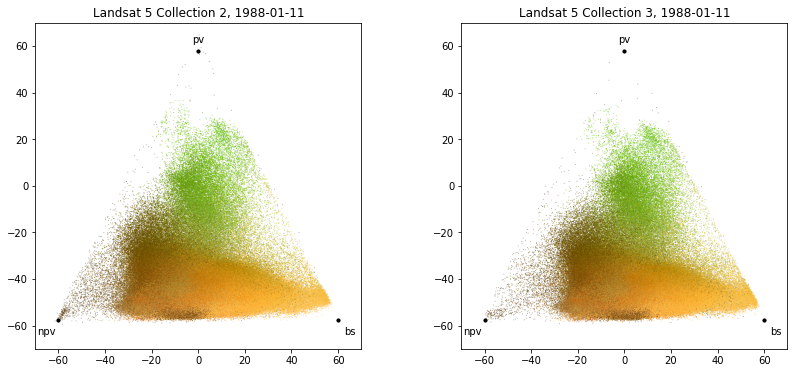

In [30]:
for i in products:
    if not has_data[i]:
        continue
    for t in ds_fc2[i].time:
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
        dt = pd.to_datetime(t.values).strftime('%Y-%m-%d')
        triangle_fc(ds_fc2[i].sel(time=t), ds_ard3[i].sel(time=t), axs[0], alpha=0.5)
        axs[0].set_title(f'Landsat {i} Collection 2, {dt}')
        triangle_fc(ds_fc3[i].sel(time=t), ds_ard3[i].sel(time=t), axs[1], alpha=0.5)
        axs[1].set_title(f'Landsat {i} Collection 3, {dt}')
        plt.show()
        break
    break

You can also animate that if you want:

In [ ]:
pip install celluloid

In [ ]:
animate = False
if animate:
    # This code could be improved by using xr's interpolation instead of Pandas'.
    ds_shape = ds_fc2[5].to_array().shape

#     df_fc2 = pd.DataFrame(np.transpose(ds_fc2[5].to_array().values, (1, 0, 2, 3)).reshape(len(ds_fc2[5].time), -1), index=ds_fc2[5].time.values)  # time, band, x, y

#     df_fc2 = df_fc2.resample('1W').mean()

#     df_fc2 = df_fc2.interpolate(axis=0, method='time')

#     resampled = ds_ard3[5].resample({'time': '1W'}).mean()
    daterange = pd.date_range(ds_fc2[5].time.values[0], ds_fc2[5].time.values[-1], freq='1W')
    interpolated_fc2 = ds_fc2[5].chunk({'time': -1}).interpolate_na(dim="time").interp(time=daterange).chunk({'time': 1}).load()
    interpolated = ds_ard3[5].chunk({'time': -1}).interpolate_na(dim="time").interp(time=daterange).chunk({'time': 1}).load()

    from tqdm.auto import tqdm
    from celluloid import Camera

    fig, ax = plt.subplots(figsize=(6, 6))
    camera = Camera(fig)

#     for t, row in tqdm(df_fc2.iterrows()):
    for t in tqdm(interpolated_fc2.time):
        row = interpolated_fc2.sel(time=t)#row.values.reshape(ds_shape[0], ds_shape[2], ds_shape[3])
#         bs = xr.DataArray(row[0], dims=['y', 'x'], coords={'y': ds_fc2[5].y, 'x': ds_fc2[5].x})
#         pv = xr.DataArray(row[1], dims=['y', 'x'], coords={'y': ds_fc2[5].y, 'x': ds_fc2[5].x})
#         npv = xr.DataArray(row[2], dims=['y', 'x'], coords={'y': ds_fc2[5].y, 'x': ds_fc2[5].x})
#         row = xr.Dataset({'bs': bs, 'pv': pv, 'npv': npv})
        dt = pd.to_datetime(t.values).strftime('%Y-%m-%d')
        triangle_fc(row, interpolated.sel(time=t, method='nearest'), ax, alpha=0.5)
        ax.text(0.02, 0.98, dt, transform=ax.transAxes, ha='left', va='top')
        camera.snap()
    
    animation = camera.animate()
    animation.save('animation3.mp4')

## Difference statistics

Let's get the mean and standard deviation for the difference between the two collections. Again, we'll do this for each scene and for all scenes. We can also do this for the median.

In [31]:
verbose = False
for i in products:
    if not has_data[i]:
        continue
    if verbose:
        print(f'Landsat {i}')
    xs = []
    ys_mean = []
    ys_stdev = []
    for t in ds_fc2[i].time:
        xs.append(t.values)
        dt = pd.to_datetime(t.values).strftime('%Y-%m-%d')
        diff = ds_fc2[i].sel(time=t) - ds_fc3[i].sel(time=t)
        diff = diff[['pv', 'npv', 'bs']].to_array()
        mean = diff.mean(axis=(1, 2))
        stdev = diff.std(axis=(1, 2))
        if verbose:
            print(f'\t{dt}')
            for band, m, s in zip(['pv', 'npv', 'bs'], mean.values, stdev.values):
                print(f'\t\t{band.upper():>3}: {m:0.2f} +- {s:.02f}')
        ys_mean.append(mean.values)
        ys_stdev.append(stdev.values)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(pd.to_datetime(xs), ys_mean)
    plt.legend(['PV', 'NPV', 'BS'])
    plt.xlabel('Date')
    plt.ylabel('Mean offset')
    plt.title(f'Landsat {i} / Mean offset')
    plt.subplot(1, 2, 2)
    plt.plot(pd.to_datetime(xs), ys_stdev)
    plt.legend(['PV', 'NPV', 'BS'])
    plt.xlabel('Date')
    plt.ylabel('Standard deviation of difference')
    plt.title(f'Landsat {i} / Standard deviation')
    plt.show()

/env/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


KeyboardInterrupt: 

In [25]:
for i in products:
    if not has_data[i]:
        continue
    print(f'Landsat {i} time-averaged offset')
    diff = ds_fc2[i] - ds_fc3[i]
    diff = diff[['pv', 'npv', 'bs']].to_array()
    mean = diff.mean(axis=(1, 2, 3))
    stdev = diff.std(axis=(1, 2, 3))
    for band, m, s in zip(['pv', 'npv', 'bs'], mean.values, stdev.values):
        print(f'\t{band.upper():>3}: {m:0.2f} +- {s:.02f}')

Landsat 5 time-averaged offset
	 PV: 0.40 +- 1.73
	NPV: 2.33 +- 2.99
	 BS: -3.11 +- 2.68
Landsat 7 time-averaged offset
	 PV: 1.05 +- 1.59
	NPV: -3.80 +- 3.15
	 BS: 2.36 +- 2.83
Landsat 8 time-averaged offset
	 PV: 1.87 +- 2.83
	NPV: -4.62 +- 3.50
	 BS: 2.40 +- 3.49


In [1]:
for i in products:
    if not has_data[i]:
        continue
    print(f'Landsat {i} (median) offset')
    diff = median_fc2[i] - median_fc3[i]
    diff = diff[['pv', 'npv', 'bs']].to_array()
    mean = diff.mean(axis=(1, 2))
    stdev = diff.std(axis=(1, 2))
    for band, m, s in zip(['pv', 'npv', 'bs'], mean.values, stdev.values):
        print(f'\t{band.upper():>3}: {m:0.2f} +- {s:.02f}')

NameError: name 'products' is not defined

## Number of saturated FC pixels

The number of pixels exactly on the boundary of the FC triangle seems to have decreased in Collection 3. This is probably a good thing, but let's quantify it.

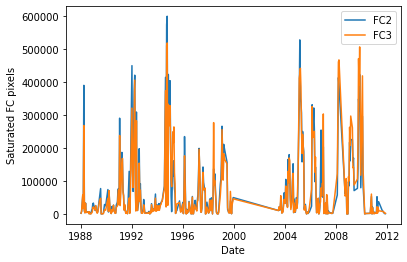

Landsat 5 C2 mean saturated FC pixels: 72231 +- 107887
Landsat 5 C3 mean saturated FC pixels: 70743 +- 107395


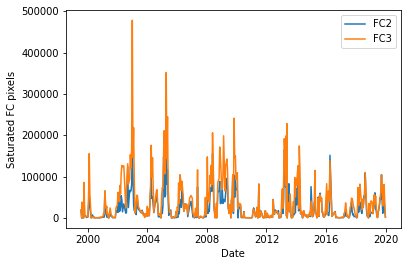

Landsat 7 C2 mean saturated FC pixels: 24621 +- 33197
Landsat 7 C3 mean saturated FC pixels: 40620 +- 55687


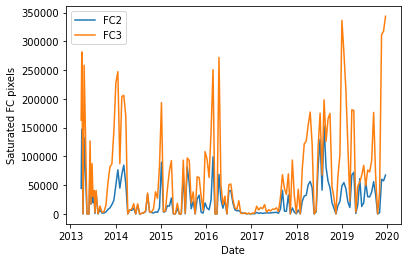

Landsat 8 C2 mean saturated FC pixels: 24617 +- 31212
Landsat 8 C3 mean saturated FC pixels: 67774 +- 82153


In [26]:
verbose = False
for i in products:
    if not has_data[i]:
        continue
    if verbose:
        print(f'Landsat {i}')
    xs = []
    ys_2 = []
    ys_3 = []
    for t in ds_fc2[i].time:
        xs.append(t.values)
        dt = pd.to_datetime(t.values).strftime('%Y-%m-%d')
        fc2 = ds_fc2[i].sel(time=t)
        fc3 = ds_fc3[i].sel(time=t)
        n_boundary_fc2 = ((fc2.bs == 0) | (fc2.pv == 0) | (fc2.npv == 0)).sum()
        n_boundary_fc3 = ((fc3.bs == 0) | (fc3.pv == 0) | (fc3.npv == 0)).sum()
        if verbose:
            print(f'\t{dt}: {n_boundary_fc2} saturated in C2, {n_boundary_fc3} saturated in C3')
        ys_2.append(n_boundary_fc2)
        ys_3.append(n_boundary_fc3)
    plt.figure()
    plt.plot(pd.to_datetime(xs), ys_2, label='FC2')
    plt.plot(pd.to_datetime(xs), ys_3, label='FC3')
    plt.xlabel('Date')
    plt.ylabel('Saturated FC pixels')
    plt.legend()
    plt.show()
    print(f'Landsat {i} C2 mean saturated FC pixels: {np.mean(ys_2):.0f} +- {np.std(ys_2):.0f}')
    print(f'Landsat {i} C3 mean saturated FC pixels: {np.mean(ys_3):.0f} +- {np.std(ys_3):.0f}')